# **Image Classification Using Vanilla Neural Networks**

Let's see how a neural network can be trained to perform image classification in Pytorch.

Start out by installing pytorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

The required libraries can now be imported

In [0]:
import os

import numpy as np

import torch
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## MNIST 

Pytorch expects `Dataset` objects as input. Luckily, for MNIST (and few other datasets such as CIFAR and SVHN), torchvision has a ready made function to convert the dataset to a pytorch `Dataset` object. Keep in mind that these functions return `PIL` images so you will have to apply a transformation on them. 

In [3]:
path = os.path.join(os.getcwd(), "MNIST")
transform = transforms.Compose([transforms.ToTensor()])
train_mnist = MNIST(path, train=True, transform=transform, download=True)
test_mnist = MNIST(path, train=False, transform=transform)

Processing...
Done!


### Visualize Dataset

Let's visualize the dataset to get a rough idea about how it looks like. It also serves as a good sanity check to make sure that everything is in order. A dataset is loaded using a `DataLoader`.

In [0]:
batch_size = 1
train_set = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)
test_set = DataLoader(test_mnist, batch_size=batch_size, shuffle=True)

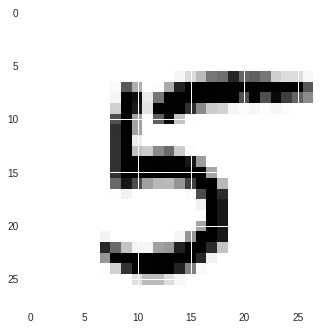

label: tensor([5])


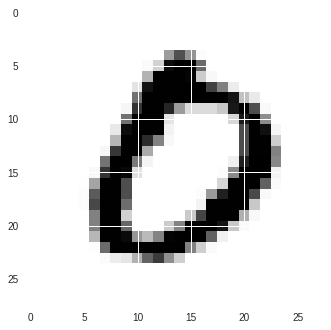

label: tensor([0])


In [7]:
num_images = 2

for i, (image, label) in enumerate(train_set):
    if i == num_images:
        break
    #Pytorch returns batch_size x num_channels x 28 x 28
    plt.imshow(image[0][0])
    plt.show()
    print("label: " + str(label))

### Train a Model

Set `batch_size` to start training a model on the dataset.

In [0]:
batch_size = 64
train_set = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

Define a `NN` model to train on MNIST

In [0]:
def identity():
    return lambda x: x
  

class NN1(nn.Module):
    def __init__(self, num_inputs=784, num_hidden=10, num_classes=10, activation=identity()):
        super().__init__()

        self.linear1 = nn.Linear(num_inputs, num_hidden, bias=True)
        self.activation = activation
        
        self.linear2 = nn.Linear(num_hidden, num_classes, bias=True)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        reshaped_x = x.view(x.size(0), -1)
        h = self.linear1(reshaped_x)
        h = self.activation(h)
        h = self.linear2(h)
        h = self.log_softmax(h)
        return h

Create a function to train the model

In [0]:
def train_model(model, train_set, optimizer):
    model.train()
    epoch_accuracy, epoch_loss = 0, 0
    train_set_size = 0
    for images, labels in train_set:
        batch_size = images.size(0)
        images_var, labels_var = Variable(images), Variable(labels)

        log_probs = model(images_var)
        _, preds = torch.max(log_probs, dim=-1)

        loss = nn.NLLLoss()(log_probs, labels_var)
        epoch_loss += loss.data.numpy() * batch_size

        accuracy = preds.eq(labels_var).float().mean().data.numpy() * 100.0
        epoch_accuracy += accuracy * batch_size
        train_set_size += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_accuracy = epoch_accuracy / train_set_size
    epoch_loss = epoch_loss / train_set_size
    return model, epoch_accuracy, epoch_loss

Now create a function to test the model

In [0]:
def test_model(model, test_set):
    model.eval()
    epoch_accuracy, epoch_loss = 0, 0
    test_set_size = 0
    for images, labels in train_set:
        batch_size = images.size(0)
        images_var, labels_var = Variable(images), Variable(labels)

        log_probs = model(images_var)
        _, preds = torch.max(log_probs, dim=-1)

        loss = nn.NLLLoss()(log_probs, labels_var)
        epoch_loss += loss.data.numpy() * batch_size

        accuracy = preds.eq(labels_var).float().mean().data.numpy() * 100.0
        epoch_accuracy += accuracy * batch_size
        test_set_size += batch_size

    epoch_accuracy = epoch_accuracy / test_set_size
    epoch_loss = epoch_loss / test_set_size
    return epoch_accuracy, epoch_loss

Finally, add a function to integrate training and testing

In [0]:
def run_model(model, train_set, test_set, num_epochs):
    optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
    train_accuracies, train_losses = [], []
    test_accuracies, test_losses = [], []
    for epoch in range(num_epochs):
        model, train_accuracy, train_loss = train_model(model, train_set, optimizer)
        test_accuracy, test_loss = test_model(model, test_set)
        print("epoch {}: train_loss= {:.3}, train_accuracy= {:.4}, "
              "test_loss= {:.3}, test_accuracy= {:.4}".format(
              epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
    return model, train_accuracies, train_losses, test_accuracies, test_losses

In [13]:
(trained_model, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(NN1(), train_set, test_set, 10)

epoch 1: train_loss= 0.586, train_accuracy= 83.75, test_loss= 0.323, test_accuracy= 90.86
epoch 2: train_loss= 0.306, train_accuracy= 91.32, test_loss= 0.287, test_accuracy= 91.94
epoch 3: train_loss= 0.284, train_accuracy= 91.96, test_loss= 0.271, test_accuracy= 92.36
epoch 4: train_loss= 0.274, train_accuracy= 92.29, test_loss= 0.262, test_accuracy= 92.58
epoch 5: train_loss= 0.267, train_accuracy= 92.5, test_loss= 0.259, test_accuracy= 92.74
epoch 6: train_loss= 0.263, train_accuracy= 92.68, test_loss= 0.253, test_accuracy= 92.97
epoch 7: train_loss= 0.26, train_accuracy= 92.81, test_loss= 0.256, test_accuracy= 92.89
epoch 8: train_loss= 0.256, train_accuracy= 92.91, test_loss= 0.252, test_accuracy= 92.86
epoch 9: train_loss= 0.254, train_accuracy= 93.01, test_loss= 0.247, test_accuracy= 93.27
epoch 10: train_loss= 0.252, train_accuracy= 93.08, test_loss= 0.249, test_accuracy= 93.13


Plot losses and accuracies

In [0]:
def plot(train_stats, test_stats, title, train_label, test_label, loc):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(train_stats, label=train_label)
    plt.plot(test_stats, label=test_label)
    plt.legend(loc=loc)

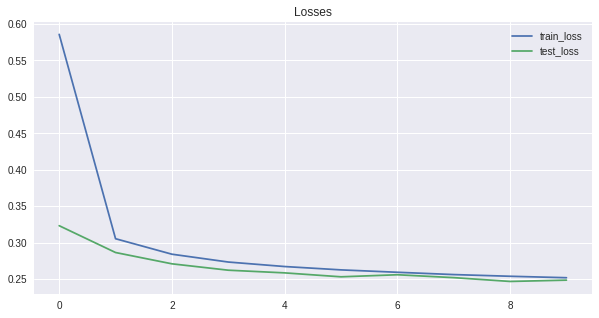

In [15]:
plot(train_losses, test_losses, "Losses", 'train_loss', 'test_loss', 'upper right')

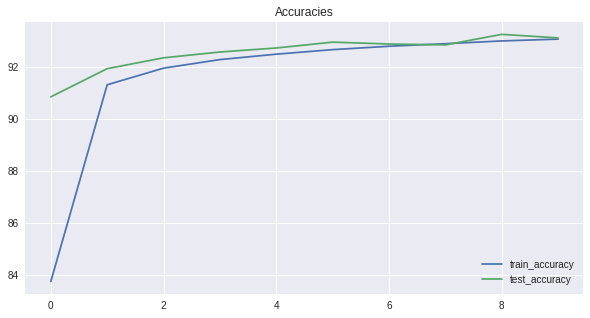

In [16]:
plot(train_accuracies, test_accuracies, "Accuracies", 'train_accuracy', 
     'test_accuracy', 'lower right')

Try different number of hidden units

In [17]:
(trained_model2, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(NN1(num_hidden=1000), train_set, test_set, 10)

epoch 1: train_loss= 0.367, train_accuracy= 89.45, test_loss= 0.318, test_accuracy= 90.73
epoch 2: train_loss= 0.314, train_accuracy= 91.14, test_loss= 0.295, test_accuracy= 91.74
epoch 3: train_loss= 0.303, train_accuracy= 91.44, test_loss= 0.304, test_accuracy= 91.23
epoch 4: train_loss= 0.296, train_accuracy= 91.81, test_loss= 0.281, test_accuracy= 92.0
epoch 5: train_loss= 0.291, train_accuracy= 91.83, test_loss= 0.277, test_accuracy= 92.14
epoch 6: train_loss= 0.287, train_accuracy= 91.93, test_loss= 0.29, test_accuracy= 91.87
epoch 7: train_loss= 0.281, train_accuracy= 92.08, test_loss= 0.26, test_accuracy= 92.59
epoch 8: train_loss= 0.278, train_accuracy= 92.22, test_loss= 0.281, test_accuracy= 91.87
epoch 9: train_loss= 0.276, train_accuracy= 92.17, test_loss= 0.256, test_accuracy= 92.78
epoch 10: train_loss= 0.274, train_accuracy= 92.33, test_loss= 0.26, test_accuracy= 92.56


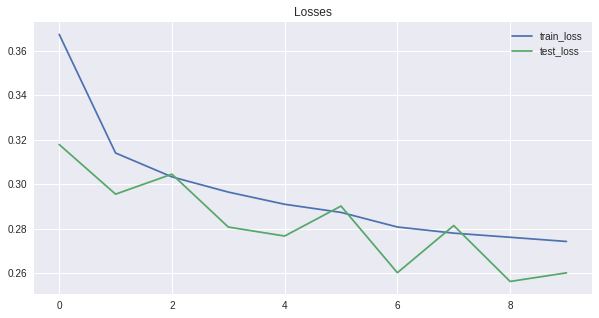

In [18]:
plot(train_losses, test_losses, "Losses", 'train_loss', 'test_loss', 'upper right')

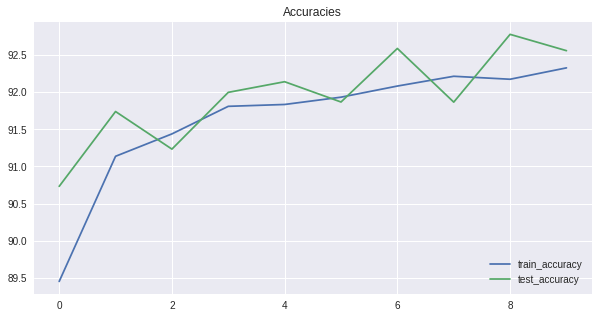

In [19]:
plot(train_accuracies, test_accuracies, "Accuracies", 'train_accuracy', 
     'test_accuracy', 'lower right')

Try different activation functions

In [20]:
(trained_model_relu, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(NN1(activation=nn.ReLU()), train_set, test_set, 10)

epoch 1: train_loss= 0.615, train_accuracy= 83.5, test_loss= 0.329, test_accuracy= 90.86
epoch 2: train_loss= 0.305, train_accuracy= 91.44, test_loss= 0.284, test_accuracy= 91.97
epoch 3: train_loss= 0.275, train_accuracy= 92.28, test_loss= 0.26, test_accuracy= 92.61
epoch 4: train_loss= 0.259, train_accuracy= 92.7, test_loss= 0.248, test_accuracy= 93.02
epoch 5: train_loss= 0.248, train_accuracy= 93.0, test_loss= 0.237, test_accuracy= 93.36
epoch 6: train_loss= 0.239, train_accuracy= 93.22, test_loss= 0.233, test_accuracy= 93.45
epoch 7: train_loss= 0.232, train_accuracy= 93.48, test_loss= 0.225, test_accuracy= 93.55
epoch 8: train_loss= 0.226, train_accuracy= 93.56, test_loss= 0.216, test_accuracy= 93.86
epoch 9: train_loss= 0.221, train_accuracy= 93.71, test_loss= 0.213, test_accuracy= 93.93
epoch 10: train_loss= 0.217, train_accuracy= 93.87, test_loss= 0.209, test_accuracy= 93.99


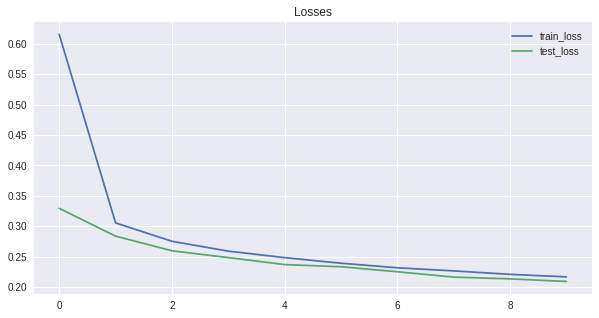

In [21]:
plot(train_losses, test_losses, "Losses", 'train_loss', 'test_loss', 'upper right')

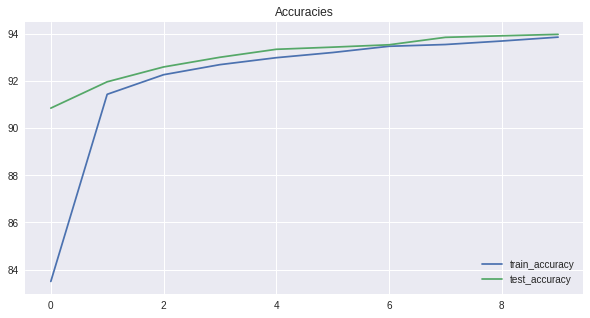

In [22]:
plot(train_accuracies, test_accuracies, "Accuracies", 'train_accuracy', 
     'test_accuracy', 'lower right')

In [23]:
(trained_model_1000, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(NN1(num_hidden=100, activation=nn.ReLU()), train_set, test_set, 20)

epoch 1: train_loss= 0.359, train_accuracy= 90.42, test_loss= 0.189, test_accuracy= 94.64
epoch 2: train_loss= 0.166, train_accuracy= 95.19, test_loss= 0.128, test_accuracy= 96.33
epoch 3: train_loss= 0.118, train_accuracy= 96.55, test_loss= 0.092, test_accuracy= 97.32
epoch 4: train_loss= 0.0901, train_accuracy= 97.35, test_loss= 0.0751, test_accuracy= 97.78
epoch 5: train_loss= 0.0731, train_accuracy= 97.86, test_loss= 0.0558, test_accuracy= 98.44
epoch 6: train_loss= 0.0601, train_accuracy= 98.2, test_loss= 0.0484, test_accuracy= 98.62
epoch 7: train_loss= 0.0495, train_accuracy= 98.55, test_loss= 0.0385, test_accuracy= 98.91
epoch 8: train_loss= 0.0423, train_accuracy= 98.76, test_loss= 0.0331, test_accuracy= 99.06
epoch 9: train_loss= 0.0352, train_accuracy= 98.97, test_loss= 0.0267, test_accuracy= 99.27
epoch 10: train_loss= 0.0298, train_accuracy= 99.19, test_loss= 0.0207, test_accuracy= 99.5
epoch 11: train_loss= 0.0254, train_accuracy= 99.28, test_loss= 0.0179, test_accuracy= 

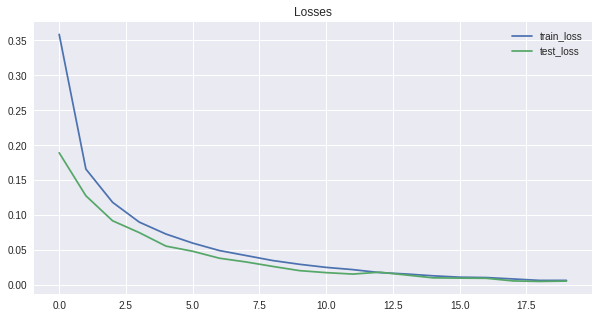

In [24]:
plot(train_losses, test_losses, "Losses", 'train_loss', 'test_loss', 'upper right')

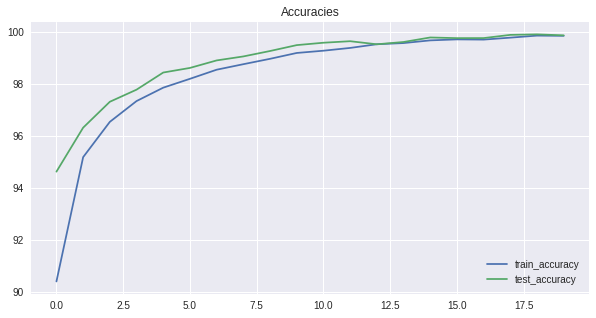

In [25]:
plot(train_accuracies, test_accuracies, "Accuracies", 'train_accuracy', 
     'test_accuracy', 'lower right')

Let's add a network that can accept different number of hidden layers

In [0]:
class Flexible_NN(nn.Module):
    def __init__(self, num_neurons=[784, 10, 10, 10], activation=identity()):
        super().__init__()
        
        self.layers = []
        for i in range(1, len(num_neurons) - 1):
            self.layers.append(nn.Linear(num_neurons[i-1], num_neurons[i]))
            self.layers.append(activation)
        
        self.layers.append(nn.Linear(num_neurons[-2], num_neurons[-1]))
        self.layers.append(nn.LogSoftmax(dim=-1))            
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        reshaped_x = x.view(x.size(0), -1)
        h = self.net(reshaped_x)
        return h

In [27]:
(deep_trained_model, train_accuracies, train_losses, test_accuracies, 
 test_losses) = run_model(Flexible_NN(num_neurons=[784, 150, 25, 10], activation=nn.ReLU()), 
                          train_set, test_set, 10)

epoch 1: train_loss= 0.369, train_accuracy= 89.44, test_loss= 0.189, test_accuracy= 94.62
epoch 2: train_loss= 0.158, train_accuracy= 95.39, test_loss= 0.121, test_accuracy= 96.49
epoch 3: train_loss= 0.11, train_accuracy= 96.72, test_loss= 0.0822, test_accuracy= 97.61
epoch 4: train_loss= 0.0833, train_accuracy= 97.49, test_loss= 0.0659, test_accuracy= 98.01
epoch 5: train_loss= 0.0654, train_accuracy= 97.98, test_loss= 0.0477, test_accuracy= 98.6
epoch 6: train_loss= 0.052, train_accuracy= 98.39, test_loss= 0.043, test_accuracy= 98.64
epoch 7: train_loss= 0.0432, train_accuracy= 98.71, test_loss= 0.0418, test_accuracy= 98.66
epoch 8: train_loss= 0.0356, train_accuracy= 98.87, test_loss= 0.026, test_accuracy= 99.28
epoch 9: train_loss= 0.0285, train_accuracy= 99.15, test_loss= 0.0245, test_accuracy= 99.22
epoch 10: train_loss= 0.0246, train_accuracy= 99.23, test_loss= 0.0183, test_accuracy= 99.47


Let's see how good this model is on some test set samples

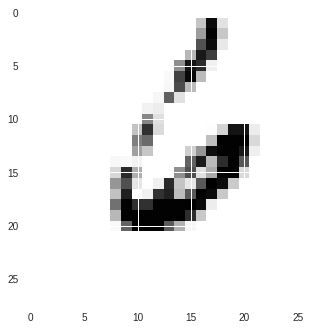

label:  tensor([6])
Model probabilities: [[0.    0.    0.09  0.    0.003 0.    0.907 0.    0.001 0.   ]]
Model prediction:  tensor([6])


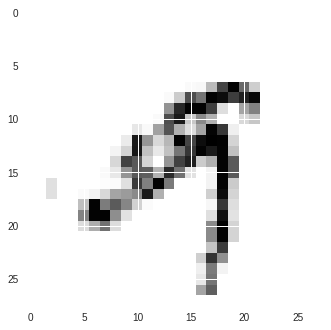

label:  tensor([9])
Model probabilities: [[0.    0.001 0.001 0.841 0.002 0.01  0.    0.003 0.007 0.134]]
Model prediction:  tensor([3])


In [31]:
num_inputs = 2
batch_size = 1
test_set = DataLoader(test_mnist, batch_size=batch_size, shuffle=True)

for i, (test_image, test_label) in enumerate(test_set):
    if i == num_inputs:
          break
    plt.imshow(test_image[0][0])
    plt.show()
    print("label: ", test_label)
    out = trained_model(test_image)
    print("Model probabilities: {}".format(torch.exp(out).data.numpy().round(3)))
    print("Model prediction: ", out.max(-1)[1])